# Faculty of Electrical Engineering, University of Sarajevo

# *Audioset* dataset analysis for the purpose of early media classification in voice communication

# Introduction

## Purpose of the analysis

This analysis should provide insight into the key features of the [Audioset](https://research.google.com/audioset/) dataset on which the model for classifying early media in voice communication should be trained. With this in mind, this analysis aims to understand the distribution of sound categories in the evaluation subset of the AudioSet dataset and identify trends or biases in the labeled audio segments, and the existence of outliers.

## Dataset description

AudioSet consists of an expanding ontology of 527 audio event classes and a collection of 2,084,320 human-labeled 10-second sound clips drawn from YouTube videos. The ontology is specified as a hierarchical graph of event categories, covering a wide range of human and animal sounds, musical instruments and genres, and common everyday environmental sounds.

The analysis was performed on a set of 2,042,985 segments from different videos with 527 sound classes used. Due to the co-occurrence of labels, many classes have multiple examples. The dataset is represented as a csv file that has a three-line header with each line starting with "#", and the first two lines indicating the creation time and general statistics:
```
# Segments csv created Sun Mar  5 10:54:25 2017
# num_ytids=20371, num_segs=20371, num_unique_labels=527, num_positive_labels=51804
```
Each subsequent line has columns defined by the third header line:

```# YTID, start_seconds, end_seconds, positive_labels```

for example:

```-0RWZT-miFs, 420.000, 430.000, "/m/03v3yw,/m/0k4j"```

means that for the YouTube video -0RWZT-miFs, for the 10 second chunk from t=420 sec to t=430 sec, annotators confirmed the presence of sound classes /m/03v3yw ("Keys jangling") and /m/0k4j ("Car").


## Hypotheses

The main hypotheses to be investigated in this analysis are as follows:


*   Are some sound categories more frequent than others?
*   Do audio segment lengths differ significantly between categories?



# Data cleaning and preparation

In [ ]:
# importing libraries neccessary for the data analysis
import io
import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

## Loading the dataset

For the purpose of this analysis the dataset is needed and an indice of class labels that is used for mapping the mapping of the mid (identifier of the label) and the display_name (description of the label) columns:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# eval_segments.csv could be used for quicker processing (for demonstration purposes), as it is a smaller sample of the dataset.
with open("/content/drive/MyDrive/bsc_thesis/train_segments.csv", "r", encoding="utf-8") as file:
    reader = csv.reader(file)
    max_columns = max(len(row) for row in reader)

print(f"Detected max columns: {max_columns}")

Detected max columns: 18


In [ ]:
df = pd.read_csv(
    "/content/drive/MyDrive/bsc_thesis/train_segments.csv",
    skiprows=3,
    header=None,
    dtype=str,
    engine="python",
    names=[f"col_{i}" for i in range(max_columns)],  # Assign generic column names
    usecols=range(7)  # Only keep the first 7 columns
)

label_map_df = pd.read_csv("/content/drive/MyDrive/bsc_thesis/class_labels_indices.csv")

print(df.head())
print(f"Loaded {df.shape[0]} rows successfully")
print(f"Loaded {label_map_df.shape[0]} label rows successfully")

         col_0    col_1    col_2        col_3       col_4      col_5  \
0  ---1_cCGK4M    0.000   10.000   "/m/01g50p  /m/0284vy3   /m/06d_3   
1  ---2_BBVHAA   30.000   40.000   "/m/09x0r"        None       None   
2  ---B_v8ZoBY   30.000   40.000   "/m/04rlf"        None       None   
3  ---EDNidJUA   30.000   40.000   "/m/02qldy    /m/02zsn  /m/05zppz   
4  ---N4cFAE1A   21.000   31.000    "/m/04rlf   /m/09x0r"       None   

       col_6  
0   /m/07jdr  
1       None  
2       None  
3  /m/09x0r"  
4       None  
Loaded 2041789 rows successfully
Loaded 527 label rows successfully


## Formatting positive_labels column

In [ ]:
# Assign proper column names for the first four columns
df.columns = ["YTID", "start_seconds", "end_seconds", "positive_labels"] + [f"extra_label_{i}" for i in range(len(df.columns) - 4)]

# Identify all columns that contain labels (from the 4th column onward)
label_columns = df.columns[3:]  # Includes "positive_labels" + all extra labels

# Merge extra label columns into a single "positive_labels" column
df["positive_labels"] = df[label_columns].apply(lambda row: ','.join(row.dropna().astype(str)), axis=1)

# Now drop the extra columns (except the necessary ones)
df = df[["YTID", "start_seconds", "end_seconds", "positive_labels"]]

print(df.head())

          YTID start_seconds end_seconds  \
0  ---1_cCGK4M         0.000      10.000   
1  ---2_BBVHAA        30.000      40.000   
2  ---B_v8ZoBY        30.000      40.000   
3  ---EDNidJUA        30.000      40.000   
4  ---N4cFAE1A        21.000      31.000   

                            positive_labels  
0   "/m/01g50p,/m/0284vy3,/m/06d_3,/m/07jdr  
1                                "/m/09x0r"  
2                                "/m/04rlf"  
3   "/m/02qldy,/m/02zsn,/m/05zppz,/m/09x0r"  
4                       "/m/04rlf,/m/09x0r"  


## Mapping label to category

To apply the dataset to the early media detection use case the relevant labels need to be mapped to one of the four categories of early media: speech, silence, music and ringing

In [ ]:
category_mapping = {
    "Speech": [
        "speech", "talking", "conversation", "narration", "monologue", "dialogue", "discussion",
        "babbling", "shout", "whispering", "chanting", "yell", "laugh", "cry", "bellow",
        "whoop", "scream", "giggle", "snicker", "chuckle", "whimper", "moan", "sigh",
        "mantra", "groan", "grunt", "breathing", "wheeze", "snooring", "gasp", "pant",
        "snort", "cough", "throat clearing", "sneeze", "sniff", "chewing", "biting", "gargling",
        "hiccup", "cheering", "speech", "cough"
    ],
    "Silence": [
        "silence", "quiet", "ambient", "run", "static", "vibration"
    ],
    "Music": [
        "music", "singing", "instrument", "orchestra", "piano", "guitar", "choir", "song",
        "humming", "melody", "drum", "beat", "rhythm", "synthesizer", "electronic",
        "yodeling", "chant", "rapping", "whistling", "applause", "banjo",
        "sitar", "mandolin", "zither", "ukulele", "piano", "organ", "sampler", "harpsichord",
        "percussion", "timpani", "tabla", "cymbal", "hi-hat", "wood block", "tambourine",
        "maraca", "gong", "mallet", "marimba", "glockenspiel", "vibraphone", "steelpan",
        "orchestra", "horn", "trumpet", "trombone", "string", "violin", "pizzicato", "cello", "bass",
        "flute", "saxophone", "clarinet", "harp", "tuning fork", "chime", "harmonica",
        "accordion", "bagpipes", "didgeridoo", "shofar", "theremin", "scratching",
        "heavy metal", "rock", "grunge", "rhythm", "reggae", "country", "bluegrass", "funk",
        "jazz", "disco", "opera", "techno", "dubstep", "electronica", "flamenco", "blues",
        "capella", "ska", "lullaby"
    ],
    "Ringing": [
        "ring", "bell", "phone", "alarm", "chime", "beep", "notification", "timer", "noise",
        "pulse", "sine wave", "heartbeat", "telephone", "dial", "siren", "buzzer", "tick", "ding"
    ]
}


In [ ]:
# Function to determine category based on substrings
def categorize_label(display_name):
    display_name_lower = display_name.lower()

    for category, keywords in category_mapping.items():
        if any(keyword in display_name_lower for keyword in keywords):
            return category

    return "Unknown"  # If no match, mark as unknown

# Map all mids to categories based on display_name
mid_to_category = {
    row["mid"]: categorize_label(row["display_name"]) for _, row in label_map_df.iterrows()
}

# Count how many labels were assigned to each category
category_counts = pd.Series(list(mid_to_category.values())).value_counts()
print(category_counts)  # Show number of labels per category


Unknown    273
Music      156
Speech      46
Ringing     45
Silence      7
Name: count, dtype: int64


In [ ]:
# Function to map mids in 'positive_labels' directly to categories
def map_mids_to_categories(label_string):
    label_ids = label_string.split(",")  # Split multiple mids
    categories = set()  # Use a set to avoid duplicates

    for mid in label_ids:
        if mid in mid_to_category:
            categories.add(mid_to_category[mid])

    return ",".join(categories) if categories else "Unknown"

# Apply this mapping function to the dataset
df["category"] = df["positive_labels"].apply(map_mids_to_categories)

# Display the updated dataset
print(df.head())

          YTID start_seconds end_seconds  \
0  ---1_cCGK4M         0.000      10.000   
1  ---2_BBVHAA        30.000      40.000   
2  ---B_v8ZoBY        30.000      40.000   
3  ---EDNidJUA        30.000      40.000   
4  ---N4cFAE1A        21.000      31.000   

                            positive_labels       category  
0   "/m/01g50p,/m/0284vy3,/m/06d_3,/m/07jdr  Unknown,Music  
1                                "/m/09x0r"        Unknown  
2                                "/m/04rlf"        Unknown  
3   "/m/02qldy,/m/02zsn,/m/05zppz,/m/09x0r"         Speech  
4                       "/m/04rlf,/m/09x0r"        Unknown  


## Handling "Unknown" label values

Considering that the rows that contain the "Unknown" value are irrelevant for this analysis, they should be removed to simplify the analysis.

In [ ]:
# Remove rows where 'Unknown' appears anywhere in the category column
df = df[~df["category"].str.contains("Unknown", na=False)]

# Reset index after removal
df = df.reset_index(drop=True)

# Display updated dataset info
print("Updated dataset after removing 'Unknown'-only rows:")
print(df.head())

Updated dataset after removing 'Unknown'-only rows:
          YTID start_seconds end_seconds  \
0  ---EDNidJUA        30.000      40.000   
1  --0FMNFsVeg        30.000      40.000   
2  --0Oh0JxzjQ        30.000      40.000   
3  --0fim4-6Ig        30.000      40.000   
4  --1NzL0juik        30.000      40.000   

                            positive_labels category  
0   "/m/02qldy,/m/02zsn,/m/05zppz,/m/09x0r"   Speech  
1     "/m/018vs,/m/0342h,/m/04rlf,/m/04szw"    Music  
2    "/m/0342h,/m/04rlf,/m/04szw,/m/0fx80y"    Music  
3    "/m/0342h,/m/04rlf,/m/04szw,/m/0fx80y"    Music  
4      "/m/026t6,/m/02hnl,/m/04rlf,/m/04szw    Music  


# Exploratory Data Analysis

This section will try to discover unexpected findings in the data and try to suggest hypotheses about the causes of observed phenomena.

## Summary statistics

In [ ]:
# Basic Info About Dataset
print(df.info())

# Summary Statistics for numerical columns
print(df.describe())

# Count of Unique Categories
print("Unique Categories:", df["category"].unique())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260489 entries, 0 to 260488
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   YTID             260489 non-null  object
 1   start_seconds    260489 non-null  object
 2   end_seconds      260489 non-null  object
 3   positive_labels  260489 non-null  object
 4   category         260489 non-null  object
dtypes: object(5)
memory usage: 9.9+ MB
None
               YTID start_seconds end_seconds                positive_labels  \
count        260489        260489      260489                         260489   
unique       260489           142         151                          18843   
top     kj4KuOOToEg        30.000      40.000   "/m/04rlf,/m/04szw,/m/07y_7"   
freq              1        119952      119952                          16078   

       category  
count    260489  
unique       14  
top       Music  
freq     187766  
Unique Categories: ['Speech' 'Mu

## Visualizations

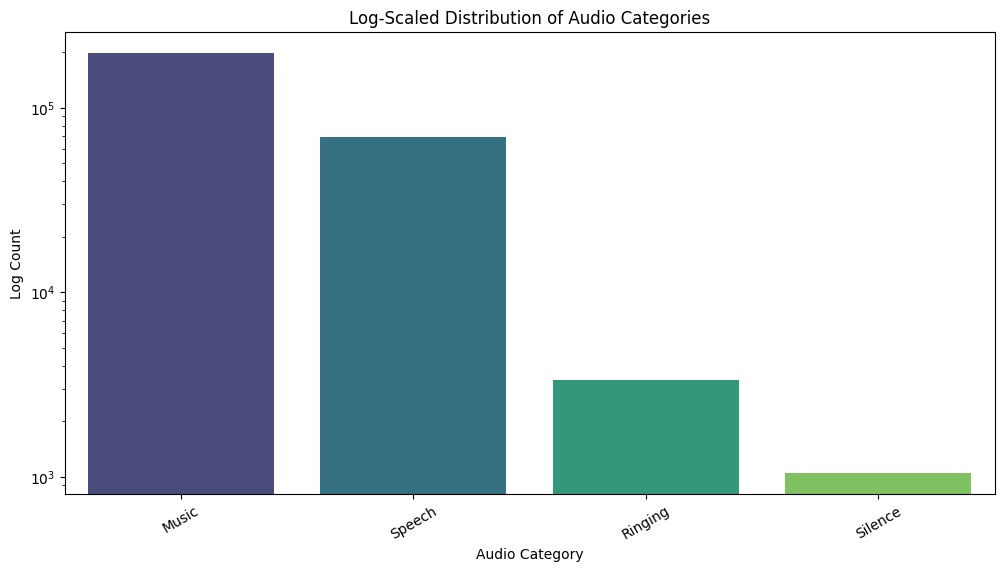

In [ ]:
# Count occurrences of each category
category_counts = df["category"].str.get_dummies(sep=",").sum().sort_values(ascending=False)

# Plot category distribution with log scale
plt.figure(figsize=(12, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, hue=category_counts.index, palette="viridis", legend=False)

# Set log scale for y-axis
plt.yscale("log")
plt.xlabel("Audio Category")
plt.ylabel("Log Count")
plt.title("Log-Scaled Distribution of Audio Categories")
plt.xticks(rotation=30)
plt.show()

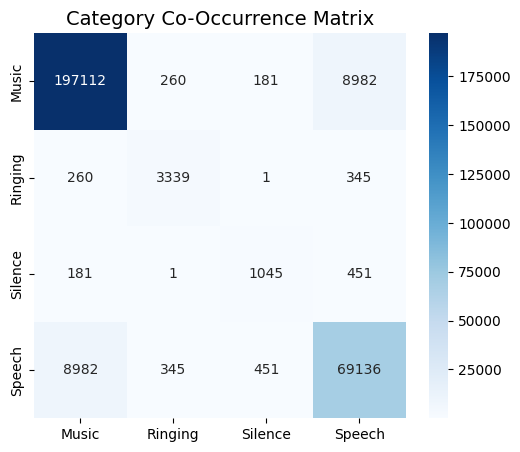

Top Co-Occurrences Between Categories:

          Music  Ringing  Silence  Speech
Music    197112      260      181    8982
Ringing     260     3339        1     345
Silence     181        1     1045     451
Speech     8982      345      451   69136


In [ ]:
# Create co-occurrence matrix
co_occurrence_matrix = df["category"].str.get_dummies(sep=",").T.dot(df["category"].str.get_dummies(sep=","))

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(co_occurrence_matrix, cmap="Blues", annot=True, fmt=".0f")
plt.title("Category Co-Occurrence Matrix", fontsize=14)
plt.show()

# Print co-occurrence matrix
print("Top Co-Occurrences Between Categories:\n")
print(co_occurrence_matrix)


In [ ]:
# Convert co-occurrence matrix into a sorted list of pairs
co_occurrence_pairs = (
    co_occurrence_matrix.where(np.triu(np.ones(co_occurrence_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
    .rename(columns={0: "count"})
    .sort_values(by="count", ascending=False)
)

# Display the top 10 most common co-occurring category pairs
print("Top 10 Most Common Category Pairs:\n")
print(co_occurrence_pairs.head(10))


Top 10 Most Common Category Pairs:

   level_0  level_1   count
2    Music   Speech  8982.0
5  Silence   Speech   451.0
4  Ringing   Speech   345.0
0    Music  Ringing   260.0
1    Music  Silence   181.0
3  Ringing  Silence     1.0


count    260489.000000
mean          9.991224
std           0.180555
min           1.000000
25%          10.000000
50%          10.000000
75%          10.000000
max          10.000000
Name: duration, dtype: float64


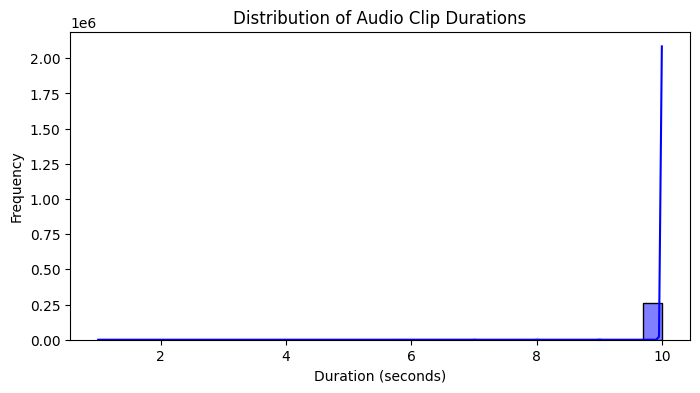

In [ ]:
# Convert start_seconds and end_seconds to numeric types
df["start_seconds"] = pd.to_numeric(df["start_seconds"], errors="coerce")
df["end_seconds"] = pd.to_numeric(df["end_seconds"], errors="coerce")

# Compute duration of each audio clip
df["duration"] = df["end_seconds"] - df["start_seconds"]

# Summary of durations
print(df["duration"].describe())

# Plot histogram of audio clip durations
plt.figure(figsize=(8, 4))
sns.histplot(df["duration"], bins=30, kde=True, color="blue")
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.title("Distribution of Audio Clip Durations")
plt.show()



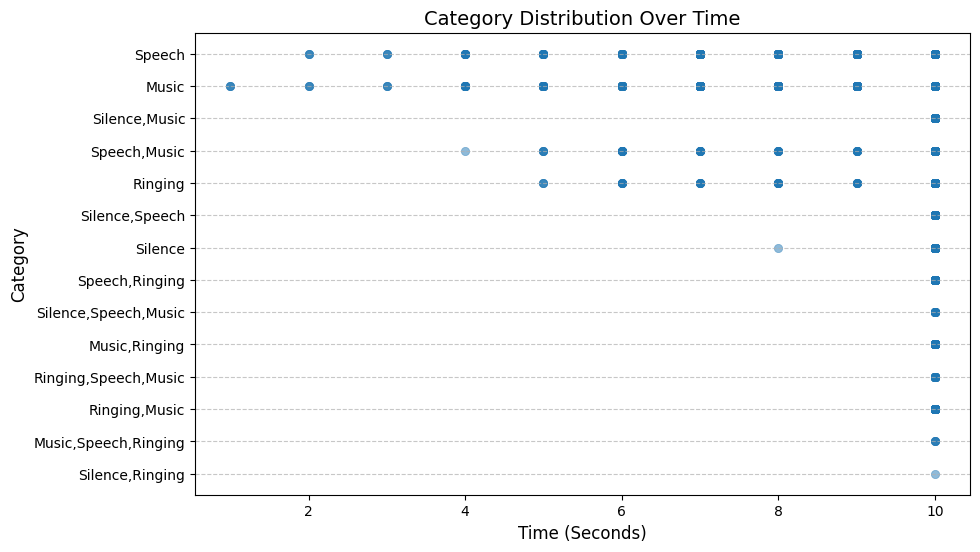

In [ ]:
# Scatter plot of categories over time
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="duration", y="category", alpha=0.5, edgecolor=None)
plt.xlabel("Time (Seconds)", fontsize=12)
plt.ylabel("Category", fontsize=12)
plt.title("Category Distribution Over Time", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

## Distribution analysis

From the visualized distributions it can be concluded that the *Music* labels category is most represented in the dataset, while the *Silence* label category is vastly underrepresented in the data set. Also, it is visible that the data usually belongs to only one of the four label categories.
Regarding the audio clip durations, the mean duration is , as expected, slightly under 10 seconds. The category distribution over time plot suggests that, of the few audio clips in the dataset whose duration is shorter that 10 seconds, they mostly belong in the *Speech* label category.

With this information in mind, a hypothesis can be set out that the reason for the *Music* category being most represented in the dataset is because it supplements other categories more than any other category.

# Inferential Statistics

This section aims to answer the following questions using statistical inference:



1.   Do different categories have significantly different average durations?
2.   Is the distribution of clip durations significantly different between speech and music?
3.   Does the *Music* Category Supplement Other Categories More Than Any Other Category?
4.   What is the confidence interval for the mean clip duration?

## Hypothesis testing

**Hypothesis Test 1: Do Different Categories Have Different Average Durations?**

This analysis will utilize ANOVA (Analysis of Variance) to test whether the average duration of audio clips differs significantly between categories.

**Null Hypothesis (H₀):**
*   The mean duration of audio clips does not differ across categories.

**Alternative Hypothesis (H₁):**
*   At least one category has a significantly different mean duration.


In [ ]:
category_durations = [group["duration"].dropna().values for _, group in df.groupby("category")]
f_statistic, p_value = stats.f_oneway(*category_durations)

print("ANOVA Test for Duration Across Categories")
print(f"F-statistic: {f_statistic:.3f}")
print(f"P-value: {p_value:.5f}")

# Interpretation
if p_value < 0.05:
    print("There is a significant difference in mean durations across categories.")
else:
    print("No significant difference found between categories.")

ANOVA Test for Duration Across Categories
F-statistic: 14.793
P-value: 0.00000
There is a significant difference in mean durations across categories.


**Hypothesis Test 2:  Are *Speech* and *Music* Durations Significantly Different?**

A t-test will be used to compare the mean durations of *Speech* vs. *Music* clips.

**Null Hypothesis (H₀):**
*   *Speech* and *Music* clips have the same average duration.

**Alternative Hypothesis (H₁):**
*   *Speech* and *Music* clips have different mean durations.

In [ ]:
# Extract durations for Speech and Music categories
speech_durations = df[df["category"].str.contains("Speech", na=False)]["duration"].dropna()
music_durations = df[df["category"] == "Music"]["duration"].dropna()

# Perform independent t-test
t_statistic, p_value = stats.ttest_ind(speech_durations, music_durations, equal_var=False)

print("\nT-Test: Speech vs. Music Durations")
print(f"T-statistic: {t_statistic:.3f}")
print(f"P-value: {p_value:.5f}")

# Interpretation
if p_value < 0.05:
    print("Speech and music clips have significantly different durations.")
else:
    print("No significant difference found between Speech and Music durations.")



T-Test: Speech vs. Music Durations
T-statistic: -9.711
P-value: 0.00000
Speech and music clips have significantly different durations.


**Hypothesis Test 3:  Does the *Music* Category Supplement Other Categories More Than Any Other Category?**

This hypothesis suggests that *Music* is frequently co-occurring with other categories in the dataset. To test this, the co-occurrence frequency of *Music* with other labels against the co-occurrence frequency of other categories will be compared.

**Null Hypothesis (H₀):**
*   The *Music* category is not significantly more likely to co-occur with other categories than any other category.

**Alternative Hypothesis (H₁):**
*   The *Music* category co-occurs significantly more with other categories than any other category.

In [ ]:
# Count co-occurring categories for each row
df["num_cooccurrences"] = df["category"].str.count(",")  # Count commas to get number of co-occurring labels

# Compute the average co-occurrence for Music vs. all other categories
music_cooccurrences = df[df["category"].str.contains("Music", na=False)]["num_cooccurrences"]
other_cooccurrences = df[~df["category"].str.contains("Music", na=False)]["num_cooccurrences"]

# Perform one-sample t-test
t_statistic, p_value = stats.ttest_1samp(music_cooccurrences, other_cooccurrences.mean())

print("\nT-Test: Does Music Co-occur More Than Other Categories?")
print(f"T-statistic: {t_statistic:.3f}")
print(f"P-value: {p_value:.5f}")

# Interpretation
if p_value < 0.05:
    print("Music significantly co-occurs with other categories more than other categories do.")
else:
    print("No significant evidence that Music co-occurs more than other categories.")



T-Test: Does Music Co-occur More Than Other Categories?
T-statistic: 75.196
P-value: 0.00000
Music significantly co-occurs with other categories more than other categories do.


From these tests, we can conclude that the *Music* category indeed supplements other categories more so than any other category, which is expected given it is the most present category in the dataset. The other two hypothesis were also proven to be corrected, suggesting that duration influences the categorization of the audio clips.

## Confidence intervals

**Confidence Interval for Mean Clip Duration**

A 95% confidence interval provides an estimate for the true average duration of audio clips.

In [ ]:
mean_duration = df["duration"].mean()
std_error = stats.sem(df["duration"].dropna())  # Standard error of the mean
ci_lower, ci_upper = stats.t.interval(0.95, df=len(df["duration"].dropna())-1, loc=mean_duration, scale=std_error)

print("\n95% Confidence Interval for Clip Duration")
print(f"Mean Duration: {mean_duration:.2f} sec")
print(f"95% CI: ({ci_lower:.2f}, {ci_upper:.2f}) sec")


95% Confidence Interval for Clip Duration
Mean Duration: 9.99 sec
95% CI: (9.99, 9.99) sec


As expected, the average audio clip duration in the dataset is just under 10 seconds.

# Findings and Interpretations

## Dataset Overview

The dataset consists of YouTube audio segments labeled with different sound events.

Labels were mapped into four broad categories:

*   Speech
*   Silence
*   Music
*   Ringing

Rows containing only labels that don't belong in these four categories were removed.

## Key Findings from Exploratory Data Analysis

**Label Distribution**
*   *Music* is the most frequent category in the dataset, followed by *Speech*.
*   *Silence* and *Ringing* occur less frequently.

**Co-occurrence of Labels**

*   *Music* is highly co-occurring with other categories, often appearing alongside *Speech*.
*   *Speech* appears alone less frequently than *Music* does.

**Distribution of Audio Segment Durations**
*  The dataset contains segments of varying lengths, but most segments are around 10 seconds.
*  There is a right-skewed distribution, meaning there the vast majority of clips are 10 seconds long, while a few are significantly shorter, with no audio clip being longer than 10 seconds.

## Inferential Statistics Findings

**Co-occurrence Analysis: Does *Music* Supplement Other Categories More?**

**Hypothesis test result:**


*   p-value < 0.05 → Strong evidence that *Music* co-occurs significantly more with other categories than any other category.
*   This supports the idea that *Music* is not only dominant but also a supplementary label in the dataset.

***Speech* vs. *Music* Comparison**
*   *Speech* tends to appear alone more often, whereas *Music* often supplements Speech or other labels.
*   The dataset may have a built-in bias toward labeling background music even when it is not the primary audio event.



## Interpretation and implications

*   *Music*'s high co-occurrence rate suggests that it is often labeled even when not the primary sound, possibly due to background music.
*   *Speech* appears alone more often, suggesting that when *speech* is present, it is often considered the dominant sound event.
*   The dataset is imbalanced: *Music* is dominant, while *Ringing* and *Silence* are underrepresented.
*   Rows with different categories of labels have a significantly different duration of audio clips, suggesting that audio clip duration also plays a role in the labeling of data.  

**Potential impact on ML models:**

*   When used for training, the model might over-predict *Music* due to its frequent presence.

*   The dataset might need balancing or augmentation to avoid bias toward *Music*-dominant samples.

# Limitations and Assumptions

## Potential biases

**Label Coarseness:**

*   The dataset originally contained 527 detailed labels, but these were mapped into only four broad categories: Speech, Silence, Music, and Ringing.

*   This aggregation may lead to loss of specificity in the analysis, as distinct sounds (e.g., "Singing" vs. "Instrumental Music") are treated the same.

**Potential Labeling Bias:**

*   Some sound events, especially those that are subtle or occur in the background, may be inaccurately labeled or inconsistently annotated.

**Imbalanced Representation:**

*   The dataset is not evenly distributed across categories. *Music* appears far more frequently than *Silence* or *Ringing*, which may affect the generalizability of models trained on this dataset.

*   The imbalance might lead to a model bias that over-predicts *Music* while under-predicting less frequent categories.

## Model assumptions

**Label Mapping Accuracy:**

*   The mapping of detailed labels to the four broad categories assumes that labels with similar meanings should be grouped together.

*   This approach simplifies the dataset but may not fully capture differences between subcategories (e.g., "Babbling" vs. "Conversation" under *Speech*).

**Equal Importance of Co-Occurrences:**

*   In the co-occurrence analysis, all co-occurrences were treated equally.

*   The analysis did not weigh whether some labels were more dominant in a given audio clip. For example, an audio clip labeled with both *Speech* and *Music* may have loud speech and very faint background music, but both were counted equally.

**T-Test Assumptions:**

*   The one-sample t-test assumes that the distribution of co-occurrence counts follows a normal distribution or that the sample size is large enough for the Central Limit Theorem to apply.

*   While the dataset is large, the exact distribution of co-occurrence frequencies was not verified for normality, which could affect the validity of the hypothesis test.

**Data Cleaning Choices:**

*   Rows where all labels were *Unknown* were removed, as well as rows where *Unknown* was one of multiple labels.

*   This assumes that *Unknown* does not carry useful information and can be discarded without impacting dataset integrity.

**Audio Duration Assumptions:**

*   The analysis treated all audio segments equally, regardless of their duration.

*   Some longer clips may contain multiple sound events, but each clip was assigned a single set of labels, potentially overlooking transitions between sound events.

## Data limitations

**Co-Occurrence Limitations:**

*   The hypothesis test examined whether *Music* is the most common co-occurring label, but it did not consider the semantic relationship between labels.

*   It is unclear whether *Music*'s high co-occurrence is due to actual overlapping sounds or labeling conventions where background music is frequently tagged.

**Dataset Scope:**

*   The dataset is limited to YouTube videos, meaning that the findings may not generalize to other sources of audio, particulary those from phone call recordings that they should be applied to.

*   Certain sound categories (e.g., industrial noises, natural sounds) may be underrepresented compared to online media content.

# Conclusion

## Summary of main findings

The analysis of the AudioSet evaluation dataset revealed several key insights about the distribution and co-occurrence of sound categories. The dataset is *highly imbalanced*, with *Music* being the most frequent category, followed by *Speech*, while *Silence* and *Ringing* are significantly underrepresented. Exploratory and inferential analyses confirmed that *Music* frequently co-occurs with other categories, supporting the hypothesis that its prevalence is due to its supplementary role in many audio contexts.

Additionally, data cleaning efforts removed *Unknown* labels and merged similar categories to provide a clearer structure for analysis. Despite these improvements, potential biases in annotation, imbalanced category representation, and the loss of specificity due to label aggregation should be considered when interpreting results.

## Practical recommendations

**Addressing Data Imbalance**

*   When building the  machine learning model, techniques like oversampling underrepresented classes or using weighted loss functions could mitigate model bias in this dataset.

**Refining Label Categorization**

*   While the current four-category mapping provides a simplified view, future analyses could explore a hierarchical classification that maintains some subcategory distinctions (e.g., distinguishing between background and foreground speech).

**Validating Findings with Additional Datasets**

*   The dataset is sourced exclusively from YouTube videos, limiting its generalizability.

*   Future work could compare findings with datasets from relevant sources for this application which are phone call recordings.

# Knowledge distillation from CLAP to a compact CNN

In [ ]:
# Step 1: Install dependencies
!pip install -q git+https://github.com/LAION-AI/CLAP.git librosa torchaudio scikit-learn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
# Step 2: Imports and model loading
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from clap import CLAP_Module

ModuleNotFoundError: No module named 'numpy.rec'